# Imports

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.style as style 
style.use('tableau-colorblind10')

# Functions

In [3]:
def anglewrap(angList):
    # maps an 0 to 360 angle to -180 to +180
    for i in range(len(angList)):
        if (angList[i] > 180):
            angList[i] = angList[i] - 360
    return 

def wrap_to_pi(angle):
    # Better function to wrap angle
    return ((angle + np.pi) % (2 * np.pi)) - np.pi

In [4]:

def import_data(name: str, wrap = True, cleanup = True):
    file = name + ".csv"
    pdoa_data = []
    tdoa_data = []
    rx_true_r = []

    dist_meas = []
    twr_count = []
    dist_true_r = []

    with open(file, "r") as f:
        reader = csv.reader(f)
        for i, line in enumerate(reader):
            linetype = int(line[0])
            if (linetype == 0):
                # rx data, featuring pdoa, tdoa and distance
                pdoa_data += [float(line[1])]
                tdoa_data += [int(line[2])]
                rx_true_r += [float(line[3])]
            
            if (linetype == 1):
                dist_meas += [int(line[5])]
                twr_count += [int(line[6])]
                dist_true_r += [float(line[7])]

            if (linetype == 2):
                print("CIR data")
    
    if (wrap):
        # Wrap angles
        anglewrap(rx_true_r)
        anglewrap(dist_true_r)

    if (cleanup):
        # Remove extreme dist outliers:
        dist_keep_indx = [i > 1000 for i in dist_meas]
        dist_meas_filt = []
        dist_r_filt = []
        twr_count_filt = []

        out_num = 0

        for i in range(len(dist_keep_indx)):
            if dist_keep_indx[i] == True:
                dist_meas_filt += [dist_meas[i]]
                dist_r_filt += [dist_true_r[i]]
                twr_count_filt += [twr_count[i]]
            else:
                out_num += 1

        print("Num of outliers: " + str(out_num))
        # Update values
        dist_meas = dist_meas_filt
        dist_true_r = dist_r_filt
        twr_count = twr_count_filt
    
    return (pdoa_data, tdoa_data, rx_true_r, dist_meas, twr_count, dist_true_r)

In [5]:
def SER(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    n = len(y_true)
    ser = np.sqrt(np.sum(residuals**2) / (n - num_params))
    return ser

# Prepare data

In [6]:
rx_true_r = []
pdoa_data = []
dist_true_r = []
dist_meas = []

# , "m1_to_m2_rot2", "m1_to_m2_rot", "m4_to_m1_rot", "m5_to_m1_rot"

# List of measurements:
files = ["new_rot5m", "m1_to_m2_rot2", "m4_to_m1_rot", "m5_to_m1_rot"]
log_num = len(files)
for log in files:
    temp_pdoa, _, temp_rx_r, temp_dist, _, temp_dist_r = import_data(log, True, False)
    rx_true_r += [temp_rx_r]
    pdoa_data += [temp_pdoa]
    dist_true_r += [temp_dist_r]
    dist_meas += [temp_dist]

# Actually do it properly

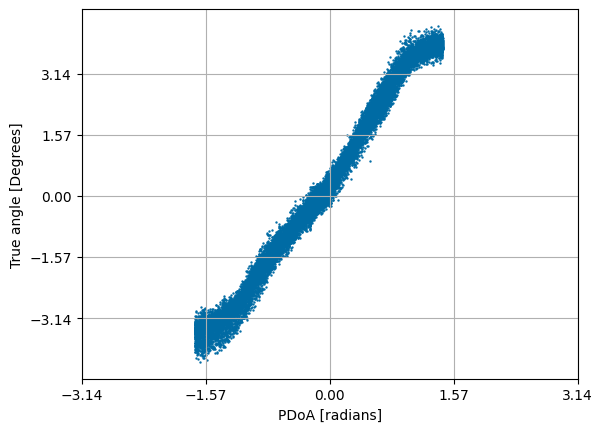

In [7]:
# alter data, to remove ambiguities:
# Mirror the data around 90 degrees axis
r_altered = []
offset = 8*(np.pi/180)
low_mirror = -np.pi/2-offset
high_mirror = np.pi/2-offset

for i in range(log_num):
    temp = np.array(rx_true_r[i])*(np.pi/180)
    temp[temp < low_mirror] = wrap_to_pi(np.pi - temp[temp < low_mirror]) - 2*offset
    temp[temp > high_mirror] = wrap_to_pi(np.pi - temp[temp > high_mirror]) - 2*offset
    r_altered += [temp]

# Move the blobs down, to kill the phase wrapping:

pdoa_altered = []

for i in range(log_num):
    temp = np.array(pdoa_data[i])
    indx1 = (temp > np.pi/2) & (r_altered[i] < 0)
    indx2 = (temp < -np.pi/2) & (r_altered[i] > 0)
    
    temp[indx1] -= 2*np.pi
    temp[indx2] += 2*np.pi

    pdoa_altered += [temp]
    
# Combine into one big numpy array
pdoa_altered2 = np.concatenate(pdoa_altered)
r_altered2 = np.concatenate(r_altered)

plt.figure()
plt.scatter(r_altered2, pdoa_altered2, s=0.5)
plt.ylabel("True angle [Degrees]")
plt.xlabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
#plt.xlim([-np.pi/2, np.pi/2])
plt.grid()



C:\Users\marcu\AppData\Local\Temp\ipykernel_10192\3513556986.py:13: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(arg)+aoff


[2.71374653 0.48904028]


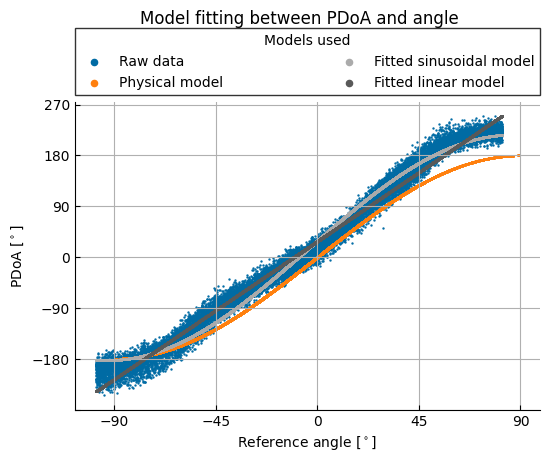

In [17]:
# Perform fitting on the altered data

def pdoa2fit(a, aoff, b, poff):
    return np.sin(a-aoff)/b - poff

def ideal_pdoa(x, d, poff, aoff):
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength

    arg = ((x+poff)*lam)/(2*np.pi*d)

    return np.arcsin(arg)+aoff

initial_guess_sin = [0, 10, 0]

params_lin = np.polyfit(r_altered2, pdoa_altered2, 1)
lin_fit = np.polyval(params_lin, r_altered2)

params_sin, covariance_sin = curve_fit(pdoa2fit, r_altered2, pdoa_altered2, p0=initial_guess_sin)
sin_fit = pdoa2fit(r_altered2, *params_sin)

params_poly5 = np.polyfit(r_altered2, pdoa_altered2, 3)
poly_fit5 = np.polyval(params_poly5, r_altered2)
params_poly7 = np.polyfit(r_altered2, pdoa_altered2, 5)
poly_fit7 = np.polyval(params_poly7, r_altered2)

ideal_fit = ideal_pdoa(pdoa_altered2, d=0.0231, poff=0, aoff=0)

#r2_sin = SER(r_altered2, sin_fit, 3)
#print(f"SER: {r2_sin:.4f}")

#r2_lin = SER(r_altered2, lin_fit, 2)
#print(f"SER: {r2_lin:.4f}")

#r2_poly = SER(r_altered2, poly_fit7, 6)
#print(f"SER: {r2_poly:.4f}")


fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(r_altered2*(180/np.pi), pdoa_altered2*(180/np.pi), s=0.5, label='Raw data')
ax.scatter(ideal_fit*(180/np.pi), pdoa_altered2*(180/np.pi), s=0.5, label='Physical model')
ax.scatter(r_altered2*(180/np.pi), sin_fit*(180/np.pi), s=0.5, label='Fitted sinusoidal model')
ax.scatter(r_altered2*(180/np.pi), lin_fit*(180/np.pi), s=0.5, label='Fitted linear model')
#ax.scatter(r_altered2*(180/np.pi), poly_fit5*(180/np.pi), s=0.5, label='3rd order poly fit')
#ax.scatter(r_altered2*(180/np.pi), poly_fit7*(180/np.pi), s=0.5, label='5th order poly fit')


ax.set_xlabel("Reference angle [$^\circ$]")
ax.set_ylabel("PDoA [$^\circ$]")
ax.set_yticks([-270, -180, -90, 0, 90, 180, 270])
ax.set_xticks([-90, -45, 0, 45, 90])
ax.grid()
ax.spines[['right', 'top']].set_visible(False)
#ax.set_ylim([-100,100])
#ax.set_xlim([-270,270])
ax.tick_params(direction='in')
fig.suptitle('Model fitting between PDoA and angle', y=1.11)
x_ticks = ax.yaxis.get_major_ticks()
x_ticks[0].label1.set_visible(False)

lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=2, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='Models used')
#lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='$d_\mathrm{ref}$')
for handle in lgnd.legend_handles:
    handle.set_sizes([20.0])
#plt.savefig("pdoa_fitted.pdf", format="pdf", bbox_inches="tight")

print(params_lin)


In [ ]:
# Check out what the error is
# First reverse the relationships:
def pdoa_rev(p, aoff, b, poff):
    return np.arcsin((p+poff)*b) + aoff

def lin_rev(p, a, b):
    return (p-b)/a

# calculate the error
err_sin = pdoa_rev(pdoa_altered2, *params_sin) - r_altered2
err_sin2 = ideal_fit - r_altered2
err_lin = lin_rev(pdoa_altered2, *params_lin) - r_altered2

std_sin = np.sqrt(np.nanvar(err_sin))
std_sin2 = np.sqrt(np.nanvar(err_sin2))
std_lin = np.sqrt(np.nanvar(err_lin))

mean_sin = np.nanmean(err_sin)
mean_sin2 = np.nanmean(err_sin2)
mean_lin = np.nanmean(err_lin)

print(std_sin2)
print(std_sin)
print(std_lin)

print(mean_sin2)
print(mean_sin)
print(mean_lin)

# Calculate the a and b coefficients

fake_a = params_lin[0]
fake_b = params_lin[1]

a = 1/fake_a
b = -fake_b/fake_a

print("coeffiencenstsys")
print(a)
print(b)

print(std_lin*3*(180/np.pi))

0.11929605626560776
0.10872945522006969
0.10446793406464332
0.16435203626454992
0.015863384572903514
1.0670627941439357e-16
coeffiencenstsys
0.36849425248756196
-0.1802085336168744


C:\Users\marcu\AppData\Local\Temp\ipykernel_10192\3944116118.py:4: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((p+poff)*b) + aoff


In [21]:
# New picewise function:

def pdoa2ang_piece(x):
    # Function for converting pdoa to angle - including all the possible ambiguities
    
    a = 0.36849425248756196
    b = -0.1802085336168744
    
    # The two thresholds
    rupp = (-np.pi/2)/a + 2*np.pi
    rlow = (np.pi/2)/a - 2*np.pi

    ang1 = a*(x)
    
    if x >= rupp:
        ang2 = a*(x-2*np.pi)
    elif x <= rlow:
        ang2 = a*(x+2*np.pi)
    else:
        # Simple case of only two ambiguities:
        mang = np.zeros(2)
        mang[0] = wrap_to_pi(ang1 + b)
        mang[1] = wrap_to_pi(np.pi - ang1 + b)

        return mang
    # More advanced case of four ambiguities:

    mang = np.zeros(4)
    mang[0] = wrap_to_pi(ang1 + b)
    mang[1] = wrap_to_pi(ang2 + b)
    mang[2] = wrap_to_pi(np.pi - ang1 + b)
    mang[3] = wrap_to_pi(np.pi - ang2 + b)

    return mang

def gen_adv_amb(x):
    
    a = 0.36849425248756196
    b = -0.1802085336168744
    
    # First generate the equivalent pdoa
    if (x < -np.pi/2 + b):
        # lower region
        pdoa = wrap_to_pi((x-b + np.pi)/-a)
    elif (x > np.pi/2 + b):
        # Upper region
        pdoa = wrap_to_pi((x-b - np.pi)/-a)
    else:
        # Middle region
        pdoa = wrap_to_pi((x-b)/a)

    mang = pdoa2ang_piece(pdoa) # Then all the ambiguities
    return mang, pdoa 

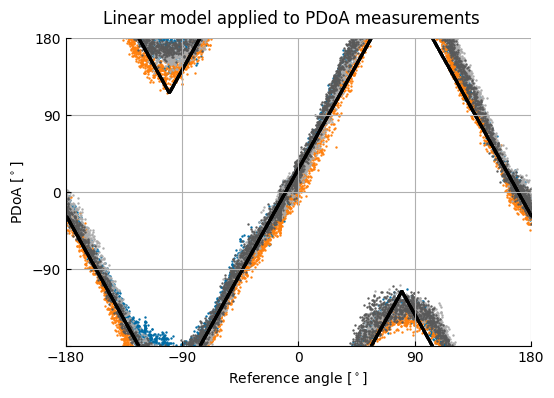

In [24]:
# Test piecewise function
dummy_pdoa = np.linspace(-np.pi,np.pi,2000)
dummy_ang = np.linspace(-np.pi, np.pi, 2000)

pdoa2plot = np.empty([0])
angle2plot = np.empty([0])
pdoa22plot = np.empty([0])
angle22plot = np.empty([0])

for pdoa in dummy_pdoa:
    temp = pdoa2ang_piece(pdoa)
    
    angle2plot = np.append(angle2plot, temp)
    pdoa2plot = np.append(pdoa2plot, np.ones_like(temp)*pdoa)

i = 0
test_pdoa = np.zeros_like(dummy_ang)
for ang in dummy_ang:
    temp, pdoa = gen_adv_amb(ang)

    test_pdoa[i] = pdoa
    angle22plot = np.append(angle22plot, temp)
    pdoa22plot = np.append(pdoa22plot, np.ones_like(temp)*pdoa)
    i += 1

# And then attempt to plot it:

fig, ax = plt.subplots(figsize=(6, 4))

for i in range(log_num):
    plt.scatter(rx_true_r[i], np.array(pdoa_data[i])*(180/np.pi), s=0.5)
plt.scatter(angle2plot*(180/np.pi), pdoa2plot*(180/np.pi), s=0.5, color='black')
#plt.scatter(angle22plot*(180/np.pi), pdoa22plot*(180/np.pi), s=0.5, color='blue')
#plt.scatter(dummy_ang*(180/np.pi), test_pdoa*(180/np.pi), s=0.5, color='red')

ax.set_xlabel("Reference angle [$^\circ$]")
ax.set_ylabel("PDoA [$^\circ$]")
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_yticks([-180, -90, 0, 90, 180])
ax.grid()
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim([-180,180])
ax.set_xlim([-180,180])
ax.tick_params(direction='in')
fig.suptitle('Linear model applied to PDoA measurements', y=0.95)
x_ticks = ax.yaxis.get_major_ticks()
x_ticks[0].label1.set_visible(False)

#lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=3, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='Models used')
#lgnd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0., scatterpoints=1, fancybox=False, edgecolor='black', title='$d_\mathrm{ref}$')
#for handle in lgnd.legend_handles:
#    handle.set_sizes([20.0])
plt.savefig("pdoa_linear.pdf", format="pdf", bbox_inches="tight")

#plt.scatter(dummy_ang, ang2pdoa(dummy_ang), s=0.5, color='black')
#plt.xlabel("True angle [Degrees]")
#plt.ylabel("PDoA [radians]")
#plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
#plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
#plt.ylim([-np.pi, np.pi])
#plt.grid()

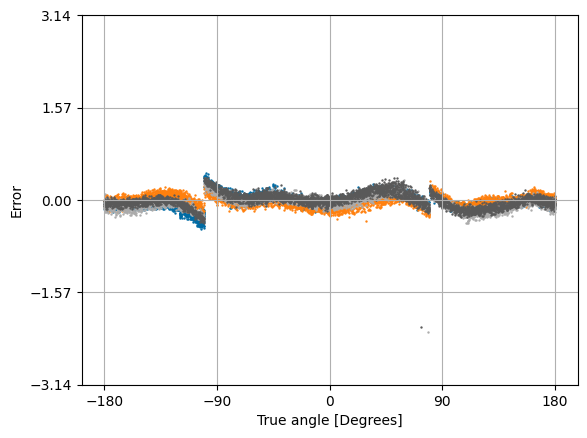

In [ ]:
# Calculate angle error

# Initialize lists

ang_errors = []

# Find errors
for i in range(log_num):
    len_pdoa = len(pdoa_data[i])

    error = np.empty([0])

    for j in range(len_pdoa):
        mang = pdoa2ang_piece(pdoa_data[i][j])
        true_val = np.ones_like(mang)*rx_true_r[i][j]*(np.pi/180)
        diff = wrap_to_pi(mang - true_val)
        min_idx = np.argmin(np.abs(diff))
        # Append error
        error = np.append(error, diff[min_idx])
    
    ang_errors += [error]

# Then plot them:

for i in range(log_num):
    plt.scatter(rx_true_r[i], ang_errors[i], s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("Error")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

In [ ]:
# Find the standard deviation:
cat_ang_error = np.empty([0])
for i in range(log_num):
    cat_ang_error = np.append(cat_ang_error, ang_errors[i])

error_thres = 1.5
filt_ang_error = cat_ang_error[np.abs(cat_ang_error) <= error_thres]

ang_mean = np.mean(filt_ang_error)
ang_var = np.var(filt_ang_error)

print("Mean: " + str(ang_mean))
print("Variance: " + str(ang_var))

Mean: -0.022646382868677366
Variance: 0.012256754831759127
